# S-parameter Exploration

Original author: David Banas <capn.freako@gmail.com>  
Original date:   June 11, 2020

Copyright &copy; 2020 David Banas; all rights reserved World wide.

This [Jupyter](http://jupyter.org) notebook was created in response to a [post](https://www.freelists.org/post/si-list/noncausal-ripples-in-impulse-response) to the [SI List](https://www.freelists.org/list/si-list) by [Tramp](mailto:farhilltramper@gmail.com), in which he inquired as to the correct method for converting the S-parameter data contained in [Touchstone](https://en.wikipedia.org/wiki/Touchstone_file) files into an _impulse response_.
It illustrates the correct method for doing this, as well as several commonly made mistakes, and can be used to explore this topic further.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Problem-Statement" data-toc-modified-id="Problem-Statement-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Problem Statement</a></span></li><li><span><a href="#First-Attempt-at-Impulse-Response-Creation" data-toc-modified-id="First-Attempt-at-Impulse-Response-Creation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>First Attempt at Impulse Response Creation</a></span><ul class="toc-item"><li><span><a href="#Types-of-ifft()-and-fft()" data-toc-modified-id="Types-of-ifft()-and-fft()-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Types of <code>ifft()</code> and <code>fft()</code></a></span></li><li><span><a href="#Transfer-Functions-of-Real-Structures" data-toc-modified-id="Transfer-Functions-of-Real-Structures-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Transfer Functions of Real Structures</a></span></li><li><span><a href="#Constructing-the-Missing-Values" data-toc-modified-id="Constructing-the-Missing-Values-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Constructing the Missing Values</a></span></li></ul></li><li><span><a href="#Correct-Implementation" data-toc-modified-id="Correct-Implementation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Correct Implementation</a></span><ul class="toc-item"><li><span><a href="#Lying-to-ifft(),-because-we-were-lied-to" data-toc-modified-id="Lying-to-ifft(),-because-we-were-lied-to-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Lying to <code>ifft()</code>, because we were lied to</a></span></li><li><span><a href="#&quot;Fixing&quot;-the-lie,-by-telling-another-(a.k.a.---windowing)" data-toc-modified-id="&quot;Fixing&quot;-the-lie,-by-telling-another-(a.k.a.---windowing)-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>"Fixing" the lie, by telling another (a.k.a. - <em>windowing</em>)</a></span></li><li><span><a href="#The-biggest-lie-of-all---a-hidden-window!" data-toc-modified-id="The-biggest-lie-of-all---a-hidden-window!-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>The biggest lie of all - a hidden window!</a></span></li></ul></li><li><span><a href="#On-the-Duality-of-Multiplication-and-Convolution" data-toc-modified-id="On-the-Duality-of-Multiplication-and-Convolution-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>On the Duality of Multiplication and Convolution</a></span></li><li><span><a href="#Closing-Thoughts" data-toc-modified-id="Closing-Thoughts-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Closing Thoughts</a></span></li></ul></div>

## Problem Statement

Before writing any code, or slogging through any algebra, let's define what we want to do.
Our starting point is a *frequency domain* description of some channel, given to us in the form of a *Touchstone* file.
Now, Touchstone files contain several pieces of information about a channel.
The piece we're interested in is the *insertion loss*, which also goes by the name: *transfer function*, often denoted as: $H(f)$.

**Note:** $H(f)$ takes a *real* (and possibly negative) argument: $f$, and returns a *complex* value: $A e^{j \phi}$ ($A$ and $\phi$ real), which gives both the *magnitude* and *phase* of the channel response at a particular frequency, $f$.

**Note:** There's a degree of freedom in the Touchstone standard that creates an ambiguity in the notation used to refer to the insertion loss component of a Touchstone file.
We will assume that the insertion loss is contained in the $S[2,1]$ component of the Touchstone file.

Our problem statement is then:

<div align="center"><em>Convert the insertion loss component of the Touchstone file into the impulse response of the channel.</em></div>

But, how do we do that?
Well, we know that the insertion loss is another name for transfer function.
And we know that the transfer function and impulse response form a Fourier transform pair:

$$
h(t) <= \mathcal{F\{ \cdot \}} => H(f)
$$

So, maybe it's as simple as: $h(t) = \text{ifft}(S[2,1])$?  
That'd be great, since just about every mathematical modeling package out there has an $\text{ifft}()$ function.

Let's try...

## First Attempt at Impulse Response Creation

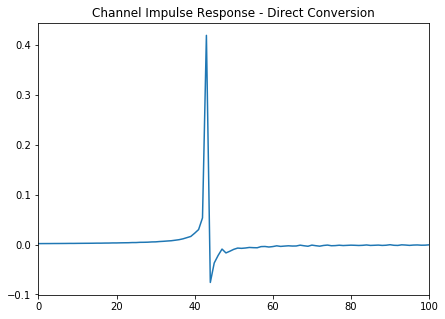

In [1]:
# Note: Change the following definition, as appropriate to your particular case.
tstone_file = '../Channels/deembedded_Diff_1_Assembly_1_Interposer_24.s4p'

# Note: Don't change anything below this line!

%matplotlib inline 
from matplotlib import pyplot as plt

import skrf as rf
import numpy as np
import scipy.signal as sig

plt.figure(figsize=(7, 5))

def sdd_21(ntwk):
    """
    Given a 4-port single-ended network, return its differential throughput."

    Note that the following connectivity is assumed:
      - 1 ==> 2
      - 3 ==> 4
    """
    return 0.5*(ntwk.s21 - ntwk.s23 + ntwk.s43 - ntwk.s41)

chnl = rf.Network(tstone_file)
s21  = sdd_21(chnl)
H    = s21.s[:,0,0]
h    = np.real(np.fft.ifft(H))
plt.plot(h)
plt.title("Channel Impulse Response - Direct Conversion")
plt.axis(xmin=0, xmax=100)
plt.show()

Hmmm, that doesn't look quite right.
What went wrong?

### Types of `ifft()` and `fft()`

Well, let's think about what the `ifft()` function expects as input.
We can figure this out pretty easily, by simply noting that: `ifft(fft(x)) = x`.
That means that the `ifft()` function expects as input whatever the `fft()` function gives as output.
Checking the docs for `fft()`:

>The values in the result follow so-called "standard" order: If ``A =
fft(a, n)``, then ``A[0]`` contains the zero-frequency term (the sum of
the signal), which is always purely real for real inputs. Then ``A[1:n/2]``
contains the positive-frequency terms, and ``A[n/2+1:]`` contains the
negative-frequency terms, in order of decreasingly negative frequency.
For an even number of input points, ``A[n/2]`` represents both positive and
negative Nyquist frequency, and is also purely real for real input.

So, in other words, if $X(f) = \text{fft}(x(t))$ then $X(f)$ has this ordering:

$$
\left[ X(0), X(f_0), X(2 f_0), ... , X((\frac{N}{2} - 1) f_0), X(f_N), X(-(\frac{N}{2} - 1) f_0), ... , X(-2 f_0), X(-f_0) \right]
$$

where:

- $f_0 = \frac{1}{N T_s}$ is the *fundamental* frequency,
- $f_N = \frac{N}{2} f_0 = \frac{1}{2 T_s} = \frac{f_s}{2}$ is the *Nyquist* frequency,
- $N$ is the number of vector samples,
- $T_s$ is the sample period, and
- $f_s = \frac{1}{T_s}$ is the sample frequency.

### Transfer Functions of Real Structures

Now, it so happens that the *transfer function* of any real structure, such as our channel, is *Hermetian*:

$$
H(-f) = H^*(f)
$$

where $H^*()$ is the *complex conjugate* of $H()$: $(A e^{j \phi})^* = A e^{-j \phi}$.

And, so, Touchstone files don't bother toting around the negative frequency values, since they can easily be calculated from the positive frequency values, for any real channel.

### Constructing the Missing Values

Now, we've identified our problem: the Touchstone file only gives us half the vector we need to feed into the `ifft()` function, because it assumes we're modeling a real structure.
How do we create the other half of the vector?
Well, since we *are* modeling a real structure, it's easy: just form a vector of the complex conjugates of the data provided by the Touchstone file and tack it onto the end, doubling the length of the vector before giving it to `ifft()`.

There are a couple subtleties, though:

1. There's a slight asymmetry in the `fft()` output vector (i.e. - expected `ifft()` input vector).

    Note that neither the $X(0)$ (i.e. - the "d.c.") term nor the $X(f_N)$ (i.e. - the "Nyquist") term has an equivalent negative frequency partner.
This breaks the otherwise perfect symmetry of the expected `ifft()` input vector and demands our attention to detail when manually assembling the vector.

2. There's no guarantee of uniform frequency stepping in a Touchstone file, but our `ifft()` function demands it.

## Correct Implementation

The following Python code illustrates the correct way to assemble the `ifft()` input vector from the Touchstone insertion loss data.

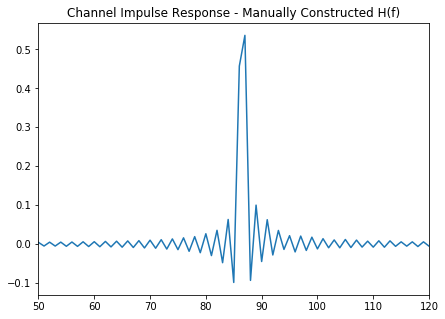

In [2]:
# Generate manually constructed frequency domain data vector.
# Form frequency vector.
f    = s21.f
fmin = f[0]
if(fmin == 0):   # If the d.c. point was included in the Touchstone file...
    fmin = f[1]  # then the next element contains the real fmin.
fmax = f[-1]
Hdc  = 1
HNyq = s21.s[-1, 0, 0]
f = np.arange(fmin, fmax, fmin)    # Enforcing uniform frequency steps. (See #2 above.)
F = rf.Frequency.from_f(f / 1e9)   # skrf.Frequency.from_f() expects its argument to be in units of GHz.

# Form impulse response from frequency response.
H     = s21.interpolate_from_f(F).s[:, 0, 0]
Hconj = np.flip(np.conj(H))
H = np.concatenate((np.insert(H, 0, Hdc), np.insert(Hconj, 0, HNyq)))  # Forming the vector that fft() would've outputted.
h = np.real(np.fft.ifft(H))

plt.figure(figsize=(7, 5))
plt.plot(h)
plt.title("Channel Impulse Response - Manually Constructed H(f)")
plt.axis(xmin=50, xmax=120)
plt.show()

That looks more reasonable, but where are those ripples coming from?
Are they real?

Let's take a look at the frequency domain vector we're sending into the `ifft()` function...

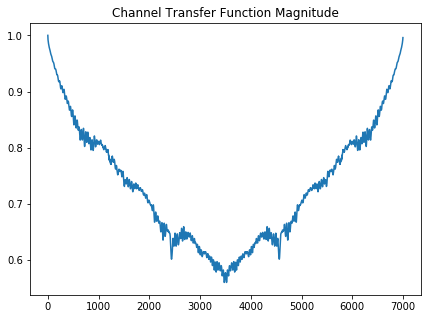

In [3]:
plt.figure(figsize=(7, 5))
plt.plot(abs(H))
plt.title("Channel Transfer Function Magnitude")
plt.show()

This looks correct.
We start at d.c. with a response of one and tail off, as we climb in frequency.
Then, when we hit the Nyquist frequency (in the center of the plot) and begin going back down in frequency (magnitude) towards d.c. again, the response climbs back towards one.
Also, the two halves of the plot look like mirror images, which is correct.
(Remember, the two halves are complex conjugates of each other; as such, they have the same magnitude.)

So, then, why the ripples in the impulse response?

### Lying to `ifft()`, because we were lied to

Let's back up a step and take a look at the insertion loss data from the original Touchstone file...

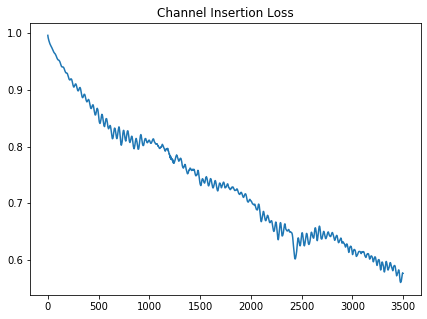

In [4]:
plt.figure(figsize=(7, 5))
plt.plot(abs(s21.s[:, 0, 0]))
plt.title("Channel Insertion Loss")
plt.show()

Notice that we simply stopped measuring the channel insertion loss while it still had significant magnitude!
Clearly, the insertion loss didn't suddenly drop to zero at the point where we arbitrarily decided to stop measuring it.
But, that's exactly what we're asking the `ifft()` function to believe; and, being just a dumb function, it has no alternative but to believe our lie.
Indeed, as far as `ifft()` is concerned, the insertion loss of our channel looks like this:

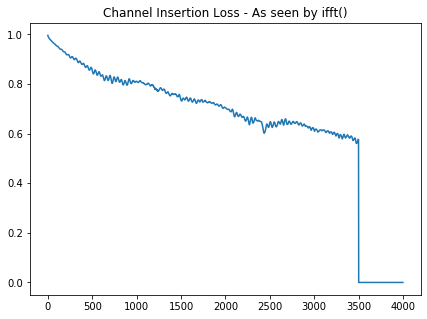

In [5]:
Hlie = np.concatenate((s21.s[:, 0, 0], np.zeros(500)))
plt.figure(figsize=(7, 5))
plt.plot(abs(Hlie))
plt.title("Channel Insertion Loss - As seen by ifft()")
plt.show()

Now, what does the *group delay* of such a channel look like?
Let's find out...

Group delay: max. =  1.31e-09; min. = -2.98e-08


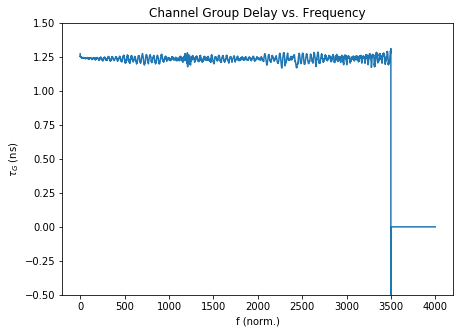

In [6]:
deltaf = f[-1] - f[-2]
flie   = np.concatenate((f, deltaf * (np.arange(501) + 1) + f[-1]))
dPhi   = np.diff(np.unwrap(np.angle(Hlie)))
df     = np.diff(flie) * 2 * np.pi
gdly   = -dPhi/df
print(f"Group delay: max. = {max(gdly):9.2e}; min. = {min(gdly):9.2e}")

plt.figure(figsize=(7, 5))
plt.plot(gdly * 1e9)
plt.title("Channel Group Delay vs. Frequency")
plt.xlabel("f (norm.)")
plt.ylabel("$\\tau_G$ (ns)")
plt.axis(ymin=-0.5, ymax=1.5)
plt.show()

And now we see the cause of our anti-causal impulse response:
We're telling the `ifft()` function that all frequencies above the point at which we stopped measuring have zero delay through our channel!

### "Fixing" the lie, by telling another (a.k.a. - *windowing*)

As disheartening as it may be to any moralists reading this, honesty is not always the best policy, when extracting channel impulse responses from Touchstone data.
Consider, we're lying to the `ifft()` function, only because we were lied to when we received incomplete insertion loss data.
However, unlike the `ifft()` function, we posess *judgement*.
And, now that we understand the *effect* of simply passing on the lie we're getting from the Touchstone file, we can apply this judgement, by "sculpting" the lie a bit before passing it on.
We call this lie sculpting *windowing*.
And the following Python code shows how it works.

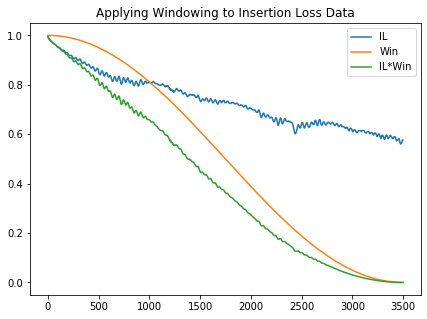

In [7]:
# Construct a "raised cosine" window apropos to the insertion loss data.
H2  = s21.interpolate_from_f(F).s[:, 0, 0]
N   = len(H2)
ix  = np.arange(N)
w   = 0.5 * (np.cos(np.pi * ix / N) + 1)
H2w = H2 * w  # windowed version of insertion loss data

plt.figure(figsize=(7, 5))
plt.plot(abs(H2),  label="IL")
plt.plot(w,        label="Win")
plt.plot(abs(H2w), label="IL*Win")
plt.title("Applying Windowing to Insertion Loss Data")
plt.legend()
plt.show()

And we see that by multiplying our insertion loss data by our *raised cosine* windowing function we've brought our new "pseudo-IL" data gently down to zero just in the nick of time, and avoided any nasty assumed "cliffs" in the channel response.
Now what happens when we use this "massaged" insertion loss data to recreate the channel impulse response?

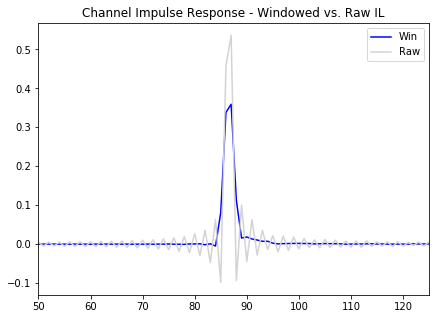

In [8]:
H2w_conj = np.flip(np.conj(H2w))
H2full   = np.concatenate((np.insert(H2w, 0, Hdc), np.insert(H2w_conj, 0, HNyq)))  # Forming the vector that fft() would've outputted.
h2 = np.real(np.fft.ifft(H2full))

plt.figure(figsize=(7, 5))
plt.plot(h2, "blue",      label="Win")
plt.plot(h,  "lightgray", label="Raw")
plt.title("Channel Impulse Response - Windowed vs. Raw IL")
plt.axis(xmin=50, xmax=125)
plt.legend()
plt.show()

And we find that by preprocessing our insertion loss data with our windowing function we have, in fact, eliminated those anti-causal ripples, at the expense of reduced peak amplitude and slight broadening of the main pulse.
(Nothing comes for free.) :(

### The biggest lie of all - a hidden window!

Many people see that raised cosine windowing function, above, and remark, "hey, why are you corrupting all that low-frequency information with your windowing function? Your problem is up at the high end of the band; why not confine the windowing effect to that area?"

Let's try that...

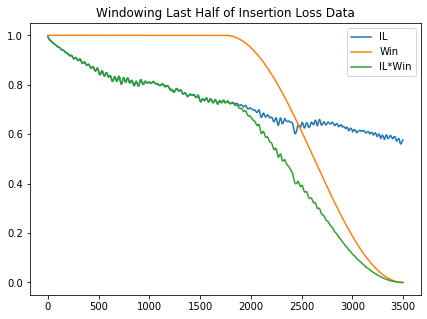

In [9]:
def win(n):
    """Form a partially windowed version of the original insertion loss data.
    
    Only the last 1/n of the original data will be 'corrupted' by the window.
    
    Return both the modified insertion loss data and the windowing function used.
    """
    M  = N // n
    ix = np.arange(M)
    w  = 0.5 * (np.concatenate((np.ones(N - M), np.cos(np.pi * ix / M))) + 1)
    Hw = H2 * w
    return (Hw, w)

H3w, w2 = win(2)

plt.figure(figsize=(7, 5))
plt.plot(abs(H2),  label="IL")
plt.plot(w2,       label="Win")
plt.plot(abs(H3w), label="IL*Win")
plt.title("Windowing Last Half of Insertion Loss Data")
plt.legend()
plt.show()

Now, as we can see in the plot above, only the last half of our original insertion loss data has been "corrupted" by our windowing function.
Let's see what sort of impulse response we get...

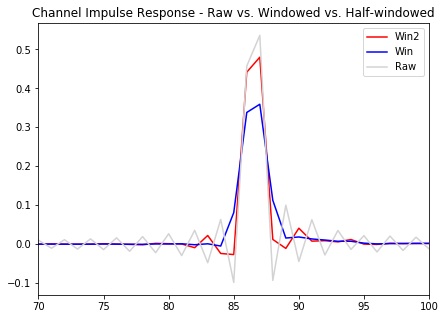

In [10]:
H3w_conj = np.flip(np.conj(H3w))
H3full   = np.concatenate((np.insert(H3w, 0, Hdc), np.insert(H3w_conj, 0, HNyq)))
h3 = np.real(np.fft.ifft(H3full))

plt.figure(figsize=(7, 5))
plt.plot(h3, "red",       label="Win2")
plt.plot(h2, "blue",      label="Win")
plt.plot(h,  "lightgray", label="Raw")
plt.title("Channel Impulse Response - Raw vs. Windowed vs. Half-windowed")
plt.axis(xmin=70, xmax=100)
plt.legend()
plt.show()

Interestingly, we've recovered some of the lost peak height and pulse broadening, but at the expense of beginning to reintroduce some anti-causal rippling.
Hmmm.
Let's trudge on a bit further.

Subjecting only the last fifth of our insertion loss data to windowing...

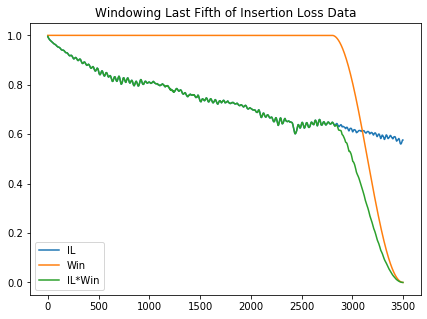

In [11]:
H4w, w3 = win(5)

plt.figure(figsize=(7, 5))
plt.plot(abs(H2),  label="IL")
plt.plot(w3,       label="Win")
plt.plot(abs(H4w), label="IL*Win")
plt.title("Windowing Last Fifth of Insertion Loss Data")
plt.legend()
plt.show()

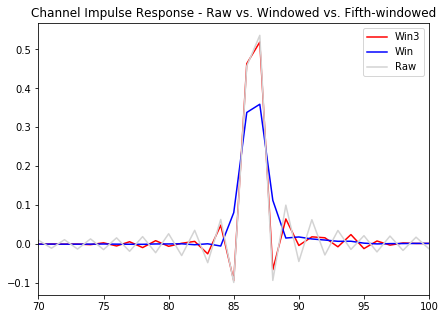

In [12]:
H4w_conj = np.flip(np.conj(H4w))
H4full   = np.concatenate((np.insert(H4w, 0, Hdc), np.insert(H4w_conj, 0, HNyq)))
h4 = np.real(np.fft.ifft(H4full))

plt.figure(figsize=(7, 5))
plt.plot(h4, "red",       label="Win3")
plt.plot(h2, "blue",      label="Win")
plt.plot(h,  "lightgray", label="Raw")
plt.title("Channel Impulse Response - Raw vs. Windowed vs. Fifth-windowed")
plt.axis(xmin=70, xmax=100)
plt.legend()
plt.show()

And, finally, subjecting only the last tenth of the original insertion loss data to windowing...

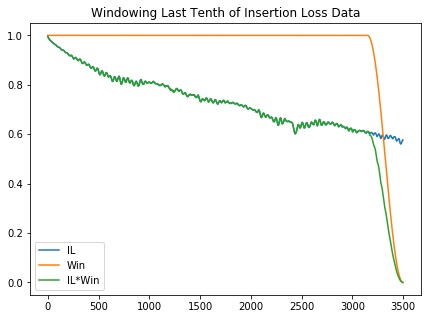

In [13]:
H5w, w4 = win(10)

plt.figure(figsize=(7, 5))
plt.plot(abs(H2),  label="IL")
plt.plot(w4,       label="Win")
plt.plot(abs(H5w), label="IL*Win")
plt.title("Windowing Last Tenth of Insertion Loss Data")
plt.legend()
plt.show()

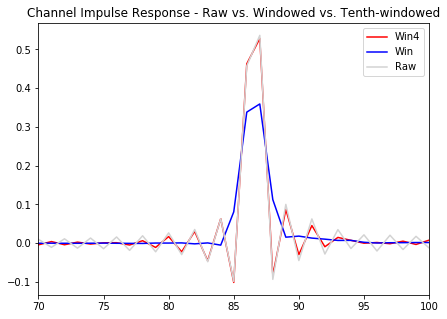

In [14]:
H5w_conj = np.flip(np.conj(H5w))
H5full   = np.concatenate((np.insert(H5w, 0, Hdc), np.insert(H5w_conj, 0, HNyq)))
h5 = np.real(np.fft.ifft(H5full))

plt.figure(figsize=(7, 5))
plt.plot(h5, "red",       label="Win4")
plt.plot(h2, "blue",      label="Win")
plt.plot(h,  "lightgray", label="Raw")
plt.title("Channel Impulse Response - Raw vs. Windowed vs. Tenth-windowed")
plt.axis(xmin=70, xmax=100)
plt.legend()
plt.show()

Hmmm, it seems we are asymptotically approaching our "Raw" waveform, as we further narrow the region of the original insertion loss data subject to our windowing.
That would imply that our "Raw", or (supposedly) un-windowed, data are, in fact, very much windowed!
Namely, the asymptotic behavior we're observing suggests that our original data have been windowed by a perfect *rectangle* function with width precisely equal to the original measurement width.
And this is precisely what has happened, and is just another way of looking at the *zero assuming* effect, which we noted above (i.e. - the one that caused a zero group delay for frequencies above the measurement limit).

## On the Duality of Multiplication and Convolution

We've begun to understand how windowing affects our resultant channel impulse response.
However, everything we've done thus far seems a little qualitative and annecdotal.
Let's see if we can reach a more quantitative and mathematically principled understanding, before we close.

We probably remember our DSP professor saying, "multiplication in the frequency domain is equivalent to convolution in the time domain", (or vice-versa).
Well, we're certainly doing some multiplication in the frequency domain when we apply our windows.
But, what are we convolving with, in the time domain?
Why, the Fourier transforms of our various windowing functions, of course!

Let's take a look at those.
We'll be careful to use the same manual assemblage process for this.

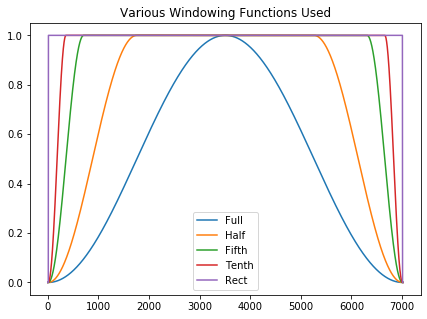

In [15]:
def conj_assem(X):
    """Form the full frequency domain vector corresponding to one of our windowing functions.
    
    Perform an fftshift on the returned vector, for plotting convenience.
    Zero pad the returned vector, such that its total length is 18x that of the input data.
    """
    X_conj = np.flip(np.conj(X))
    return np.concatenate((X, X_conj))

r = np.ones(len(w))  # Form the hidden rectangle window applied to our raw insertion loss data.
plt.figure(figsize=(7, 5))
for (f, lbl) in [(w, "Full"), (w2, "Half"), (w3, "Fifth"), (w4, "Tenth"), (r, "Rect")]:
    H = conj_assem(f)
    plt.plot(np.pad(np.fft.fftshift(H), (10,10), 'constant', constant_values=0), label=lbl)
plt.title("Various Windowing Functions Used")
plt.legend()
plt.show()

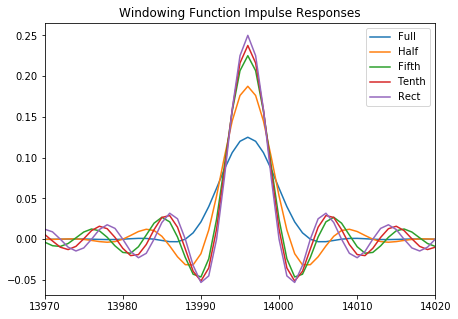

In [16]:
plt.figure(figsize=(7, 5))
for (f, lbl) in [(w, "Full"), (w2, "Half"), (w3, "Fifth"), (w4, "Tenth"), (r, "Rect")]:
    h = np.fft.fftshift(np.fft.ifft(conj_assem(np.pad(f, (0, 3*len(f)), 'constant', constant_values=0))))
    plt.plot(np.real(h), label=lbl)
plt.axis(xmin=13970, xmax=14020)
plt.title("Windowing Function Impulse Responses")
plt.legend()
plt.show()

And, finally, it's quite clear what's going on, if we consider that we're *convolving* our "real" channel impulse response with one of the window impulse response functions shown in the plot above.
In particular, note the following:

1. The "Full" window function has an impulse response that is "critically damped", in the sense that it is the only one without side lobes.

1. As we repress the ripples more and more, the price we pay is lowered main lobe height and increased main lobe width.
One way to interpret this is as lost *accuracy* and *precision*.

1. The trend towards the *rectangular* window as an asymptotic limit is made clear in the plot above, for all three features:

    - main lobe height,
    - main lobe width, and
    - size and location of ripples.

## Closing Thoughts

We've looked at how we can convert channel *insertion loss* data in a standard Touchstone file into the channel *impulse response*, presumably for further use in time domain simulations.
We've exposed the subtleties one must be aware of when feeding this raw measurement data into mathematical functions available in the standard modeling packages, such as `ifft()`, and given concrete correct examples, in the form of Python code, for doing so.
And we've shown how some pre-processing of the Touchstone data, in the form of windowing, can help improve our results, by making them causal as expected.

While the particular code examples in this notebook are written in *Python* and make use of the *NumPy*/*SciPy* libraries, the techniques illustrated are equally applicable to any language and the functions used will almost certainly be found in any serious modeling package.
Indeed, the reader should feel completely comfortable extracting, manipulating, and using Touchstone data, regardless of the particular language or modeling package she is using.